# __Predicting Outcomes of Call Option Contracts__

# SECTION 1: Preparation

##  1.1.) Loading the python packages

In [1]:

from sklearn import datasets

# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
import random

# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from evolutionary_search import EvolutionaryAlgorithmSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

#importing classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#from sklearn.metrics import balanced_accuracy_score
#from sklearn.metrics import confusion_matrix
#from imblearn.metrics import classification_report_imbalanced

#Libraries for Saving the Model
from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')



## 1.2.) Loading the Data

In [2]:
iris = datasets.load_iris()

X = iris.data

y = iris.target

validation_size = 0.2

seed = 7

In [ ]:
#Import call options info

df = pd.read_csv(
    Path("../Resources/vix_spy.csv")
)


In [ ]:
df.head()

# SECTION 2: Exploratory Data Analysis

## 2.1.) Descriptive Statistics

In [ ]:
df.shape

In [ ]:
#Check for any null values and remove the null values
print('Null Values =', df.isnull().values.any())

#Drop NaNs
df.dropna()

In [ ]:
display(df.head())
df.tail()

In [ ]:
df.describe()

In [ ]:
df.dtypes

## 2.2.) Feature Analysis and Exploration

### Plotting features according to contract length

In [ ]:
#
contract_outcome = df.groupby('STRIKE_DISTANCE_PCT')['y'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=contract_outcome.index, y=contract_outcome.values, color='#5975A4', saturation=1)

### Eliminate Uncorrelated Features

In [ ]:
#Calculate correlation of each feature with 'y'

correlation = df.corr()
correlation_df = abs(correlation['y'])

In [ ]:
correlation_df.sort_values(ascending=False)

In [ ]:
#Drop variables with less than 3% correlation with contract outcome ('y')

drop_list_corr = sorted(list(correlation_df[correlation_df < 0.03].index))
print(drop_list_corr)

In [ ]:
df.drop(labels=drop_list_corr, axis=1, inplace=True)

### Drop Columns Not Needed for Machine Learning

In [ ]:
df.drop(columns=["CONTRACT"], inplace=True)

In [ ]:
df.drop(columns=["EXPIRE_DATE"], inplace=True)

In [ ]:
df.drop(columns=["ROI %"], inplace=True)

In [ ]:
df.drop(columns=["PRICECLOSE"], inplace=True)

# SECTION 3: Evaluate Algorithms and Models

## 3.1.) Train Test Split and Evaluation Metrics

In [ ]:
#Split into training and testing groups

#Split out validation dataset for the end
y = df["y"]

X = df.drop(columns='y')


In [3]:

validation_size = 0.2

seed = 7

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [4]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [5]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Scale both the training and testing data from the features dataset
X_train_scaled = X_scaler.transform(X_train)
X_validation_scaled = X_scaler.transform(X_validation)

In [7]:
y_validation

array([2, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 2, 0, 0, 1, 2,
       1, 2, 2, 2, 1, 1, 2, 2])

## 3.2.) Quick Check of Models and Algorithms

In [8]:
#Spot check Classification algorithms

models = []

#Boosting methods

models.append(('XGB', XGBClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

#Bagging methods

models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

#SVC 
models.append(('SVC', SVC()))

In [9]:
#Test options for classification

num_folds = 3
seed = 7

In [10]:
results = []

names = []

scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    findings_summary = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(findings_summary)

XGB: 0.966667 (0.011785)
AB: 0.966667 (0.011785)
GBM: 0.966667 (0.011785)
RF: 0.966667 (0.011785)
ET: 0.975000 (0.000000)
SVC: 0.983333 (0.011785)


In [ ]:
#Compare the model outcomes

fig = pyplot.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

## 3.3.) Selecting Random Forest (or whichver tree method best), Calculating its Baseline 

In [11]:
#Estimate accuracy on training set

rf_model = RandomForestClassifier()

cv = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
scores = cross_val_score(rf_model, X_train_scaled, y_train, scoring='accuracy', cv=cv)
avg_score = np.mean(scores)
avg_score

0.975

In [12]:
#Estimate accuracy on validation set

rf_model = RandomForestClassifier()

rf_model.fit(X_train_scaled, y_train)

predictions = rf_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))

print(classification_report(y_validation, predictions, target_names=['Strong Sell', 'Sell', 'Pass']))

print(confusion_matrix(y_validation, predictions))

0.9
Weighted Precision: 0.90
Weighted Recall: 0.90
Weighted F1-score: 0.90
              precision    recall  f1-score   support

 Strong Sell       1.00      1.00      1.00         7
        Sell       0.85      0.92      0.88        12
        Pass       0.90      0.82      0.86        11

    accuracy                           0.90        30
   macro avg       0.92      0.91      0.91        30
weighted avg       0.90      0.90      0.90        30

[[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

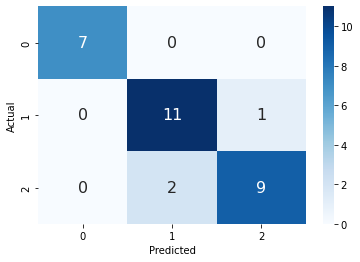

In [13]:
#Visualization of the Confusion Matrix

df_matrix = pd.DataFrame(confusion_matrix(y_validation, predictions), columns=np.unique(y_validation), index = np.unique(y_validation))
df_matrix.index.name = 'Actual'
df_matrix.columns.name = 'Predicted'
sns.heatmap(df_matrix, cmap="Blues", annot=True, annot_kws={"size": 16}) 

# SECTION 4: Model Tuning 

## 4.1.) Hyperparameter Tuning for Random Forest

### APPROACH (A)

In [ ]:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {}

paramgrid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=RandomForestClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X_train_scaled, y_train)

### APPROACH (B)

In [ ]:
# Grid Search: (select model) Tuning

n_estimators = [20, 100, 180, 1000]
max_features = [1, 2, 3, 4]

param_grid = dict(n_estimators=n_estimators, max_features=max_features)

rf_model = RandomForestClassifier()

kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

### PROCEEDING WITH BEST APPROACH

In [ ]:
#Prepare the model with parameters decided in previous cell

rf_model = RandomForestClassifier(max_features=3, n_estimators=20)
rf_model.fit(X_train_scaled, y_train)

In [ ]:
#Score predictions of training set

training_predictions = rf_model.predict(X_train_scaled)

print(accuracy_score(y_validation, predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_train, training_predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_train, training_predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_train, training_predictions, average='weighted')))


print(classification_report(y_train, training_predictions, target_names=['Strong Sell', 'Sell', 'Pass']))

In [ ]:
#Score predictions of validation set

predictions = xgb_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_validation, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_validation, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))


print(classification_report(y_validation, predictions, target_names=['Strong Sell', 'Sell', 'Pass', 'Buy', 'Strong Buy']))

print(confusion_matrix(y_validation, predictions))

In [ ]:
#Visualization of the Confusion Matrix

df_matrix = pd.DataFrame(confusion_matrix(y_validation, predictions), columns=np.unique(y_validation), index = np.unique(y_validation))
df_matrix.index.name = 'Actual'
df_matrix.columns.name = 'Predicted'
sns.heatmap(df_matrix, cmap="Blues", annot=True, annot_kws={"size": 16}) 

## 4.2.) Determining Feature Importance

In [14]:
#Feature importances

importances = rf_model.feature_importances_

In [15]:
important_features = zip(X.columns, rf_model.feature_importances_)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
importances_df = pd.DataFrame(important_features)

In [ ]:
importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

In [ ]:
importances_df = importances_df.set_index('Feature')

In [ ]:
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

In [ ]:
#Plot the top 10 most important features

importances_df[0:10].plot(
    kind='barh',
    color='green',
    title='Feature Importance',
    legend=True)

## 4.2. Bayesian Optimization with HYPEROPT for XRG

In [ ]:
#Initialize domain space for range of values 
 
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


The available hyperopt optimization algorithms are -

hp.choice(label, options) — Returns one of the options, which should be a list or tuple.

hp.randint(label, upper) — Returns a random integer between the range [0, upper).

hp.uniform(label, low, high) — Returns a value uniformly between low and high.

hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [ ]:
def objective(space):
    xgb_model = xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train_scaled, y_train), (X_validation_scaled, y_validation)]
    
    xgb_model.fit(X_train_scaled, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = xgb_model.predict(X_validation_scaled)
    accuracy = accuracy_score(y_validation, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [16]:
xgb_model = xgb.XGBClassifier()  #(colsample_bytree=0.6686069756622127, max_depth=17, gamma=1.3673617773715256, min_child_weight=2, reg_lambda=0.214836520311216, reg_alpha=0)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [17]:
#Predicting on training set

training_predictions = xgb_model.predict(X_train_scaled)

print(accuracy_score(y_train, training_predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_train, training_predictions, average='weighted')))

print(classification_report(y_train, training_predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

1.0
Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00


ValueError: Number of classes, 3, does not match size of target_names, 6. Try specifying the labels parameter

In [18]:
#Predicting on validation set

predictions = xgb_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))

print(classification_report(y_validation, predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

print(confusion_matrix(y_validation, predictions))

0.8666666666666667
Weighted Precision: 0.87
Weighted Recall: 0.87
Weighted F1-score: 0.87


ValueError: Number of classes, 3, does not match size of target_names, 6. Try specifying the labels parameter

In [19]:
#Get probabilities of predictions

pred_proba = xgb_model.predict_proba(X_validation_scaled)
pred_proba

array([[3.4100867e-03, 4.0480490e-03, 9.9254191e-01],
       [5.2471138e-03, 9.9268943e-01, 2.0633945e-03],
       [9.9289203e-01, 5.5179815e-03, 1.5899547e-03],
       [5.2471138e-03, 9.9268943e-01, 2.0633945e-03],
       [4.9798641e-02, 7.0974094e-01, 2.4046040e-01],
       [9.5324570e-01, 4.5227773e-02, 1.5264676e-03],
       [2.2742433e-02, 7.2072321e-01, 2.5653434e-01],
       [1.7086983e-03, 9.9761933e-01, 6.7193521e-04],
       [9.9289203e-01, 5.5179815e-03, 1.5899547e-03],
       [6.2238877e-03, 9.8504633e-01, 8.7298024e-03],
       [2.5349020e-03, 2.5089476e-03, 9.9495620e-01],
       [4.7067469e-03, 9.9340397e-01, 1.8892996e-03],
       [9.9289203e-01, 5.5179815e-03, 1.5899547e-03],
       [1.1614949e-03, 9.2471350e-04, 9.9791378e-01],
       [9.9289203e-01, 5.5179815e-03, 1.5899547e-03],
       [2.8813832e-02, 9.0704605e-02, 8.8048154e-01],
       [1.5653590e-03, 6.6046803e-03, 9.9182993e-01],
       [1.1614949e-03, 9.2471350e-04, 9.9791378e-01],
       [9.9289203e-01, 5.517

In [ ]:
proba_df = pd.DataFrame(pred_proba.round(2))

In [ ]:
#Formatting probabilities DataFrame

proba_df["Actual"] = y_validation
proba_df.columns = ["'Strong Sell' Probability", "'Sell' Probability", "'Pass' Probability", "'Buy' Probability", "'Strong Buy' Probability", "'Very High Return' Prob.", "Actual"]
proba_df

In [ ]:
#Labeling caterogires

proba_df.loc[proba_df["Actual"] == 0, "Actual"] = "Strong Sell"
proba_df.loc[proba_df["Actual"] == 1, "Actual"] = "Sell"
proba_df.loc[proba_df["Actual"] == 2, "Actual"] = "Pass"
proba_df.loc[proba_df["Actual"] == 3, "Actual"] = "Buy"
proba_df.loc[proba_df["Actual"] == 4, "Actual"] = "Strong Buy"
proba_df.loc[proba_df["Actual"] == 5, "Actual"] = "Very High Return"

proba_df

In [ ]:
#Get ROC AUC score

roc_auc_score(y_validation, pred_proba, multi_class="ovr")

## 4.2.) Determining Feature Importance for XGBoost Model

In [ ]:
#Feature importances

importances = xgb_model.feature_importances_

In [ ]:
important_features = zip(X.columns, xgb_model.feature_importances_)

In [ ]:
importances_df = pd.DataFrame(important_features)

In [ ]:
importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

In [ ]:
importances_df = importances_df.set_index('Feature')

In [ ]:
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

In [ ]:
#Plot the top 10 most important features

importances_df[0:10].plot(
    kind='barh',
    color='green',
    title='Feature Importance',
    legend=True)

In [ ]:
et_model = ExtraTreesClassifier()
et_model.fit(X_train_scaled, y_train)

In [ ]:
ab_model = AdaBoostClassifier()
ab_model.fit(X_train_scaled, y_train)

In [ ]:
gb_model = GradientBoostingClassifier()
ab_model.fit(X_train_scaled, y_train)